# CNN

dataset: https://www.kaggle.com/datasets/ozguraslank/brain-stroke-ct-dataset?resource=download

Reference used to read dataset:
* https://www.kaggle.com/code/ozguraslank/reading-brain-stroke-ct-dataset



In [1]:
import numpy as np  # Biblioteca para operaciones numéricas y manejo de arreglos
import matplotlib.pyplot as plt  # Biblioteca para visualización de datos en gráficos
import pandas as pd  # Biblioteca para manipulación y análisis de datos en estructuras tabulares
from sklearn.svm import SVC  # Clasificador de soporte vectorial (Support Vector Classification)
from sklearn.model_selection import GridSearchCV  # Herramienta para optimización de hiperparámetros
from sklearn.model_selection import train_test_split  # Función para dividir datos en conjuntos de entrenamiento y prueba
from sklearn.metrics import accuracy_score  # Métrica para calcular la precisión del modelo
from sklearn.metrics import classification_report, confusion_matrix  # Reporte que muestra métricas de clasificación
import os  # Módulo para interactuar con el sistema operativo
from PIL import Image  # Biblioteca para abrir, manipular y guardar imágenes
import seaborn as sns # Biblioteca para visualización de datos en gráficos


## Data processing 

In [ ]:
path = 'Brain_Stroke_CT_Dataset/'

#Path de las imágenes
normal_path = path + "Normal" + "/" + "PNG" #Debe ser así pa q funcione tipo expresion regular
ischemia_path = path + "Ischemia" + "/" + "PNG"
bleeding_path = path + "Bleeding" + "/" + "PNG"

#Path de las máscaras
ischemia_mask_path = path + "Ischemia" + "/" + "OVERLAY"
bleeding_mask_path = path + "Bleeding" + "/" + "OVERLAY"

#Obtenemos todas las imágenes
normal_folder = os.listdir(normal_path)
ischemia_folder = os.listdir(ischemia_path)
bleeding_folder = os.listdir(bleeding_path)

#Mostramos cantidad de datos por clase para ver desbalance
size_normal = len(normal_folder)
size_ischemia = len(ischemia_folder)
size_bleeding = len(bleeding_folder)
print("Normal:", size_normal)
print("Ischemia:", size_ischemia)
print("Bleeding:", size_bleeding)


Normal: 4427
Ischemia: 1130
Bleeding: 1093


In [3]:
def process_image(file_path, dim, scale):
    img = Image.open(file_path)
    img = img.convert(scale) #Escala de grises o RGB
    img = img.resize(dim) #Reescalamos
    img = np.array(img)
    return img

In [4]:
#Almacenamos todas las imágenes
data = []
dim = (256, 256) #resize

folders = [normal_folder, ischemia_folder, bleeding_folder]
paths = [normal_path, ischemia_path, bleeding_path]

for i in range(len(folders)):

    #Recorremos todos los archivos de la carpeta y path i 
    for file_name in folders[i]:
        img = process_image(paths[i] + "/" + file_name, dim, 'L') #L = escala de grises
        data.append(img)


In [5]:
#Verificamos dimensión de los datos
data = np.array(data)
data.shape

(6650, 256, 256)

In [6]:
#Creamos el vector de labels
y = np.zeros(6650)
y[:size_normal] = 0 #Normal label [0:4427]
y[size_normal:size_normal+size_ischemia] = 1 #Ishcemia label [4427: 5557]
y[size_normal+size_ischemia:] = 2   #bleeding label [5557:]
y.shape


(6650,)

### Image examples

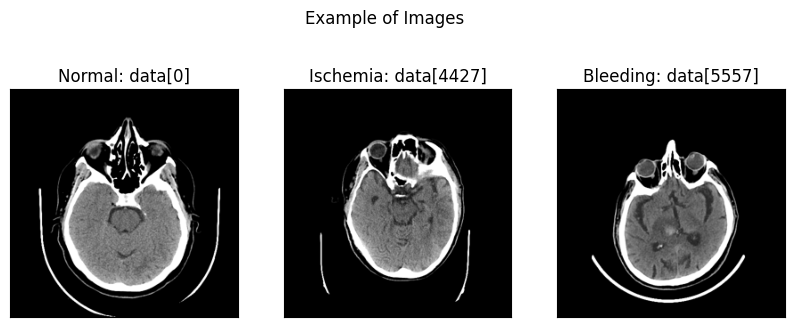

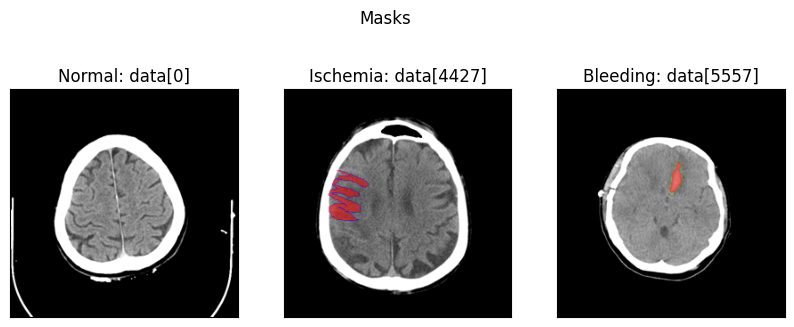

In [7]:
#Mostrmoas una imágen de ejemplo (para ver si el vector y está bien)
f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Example of Images")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(data[0], cmap="gray")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(data[4427], cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(data[5557], cmap="gray")
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


#We will also show the masks of the above pictures (manual)
data0_path =    normal_path    + "/10000.png"
data4427_path = ischemia_mask_path  + "/10003.png"
data5557_path = bleeding_mask_path  + "/10002.png"

mask_data0 = process_image(data0_path, dim, "RGB")
mask_data4427 = process_image(data4427_path, dim, "RGB")
mask_data5557 = process_image(data5557_path, dim, "RGB")

f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Masks")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(mask_data0)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(mask_data4427)
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(mask_data5557)
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


## CNN model

#### Importación de librerías

In [8]:
#Importamos las librerías necesarias

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F  

#### Configuración del dispositivo

In [9]:
# Se establece el dispositivo a utilizar: "cuda" si hay una GPU disponible, de lo contrario "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Preparación y verificación de datos

In [10]:
# Convertimos los datos y etiquetas a tensores de PyTorch
X_tensor = torch.tensor(data, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Verificar el tamaño de los tensores
print("Tamaño de X_tensor:", X_tensor.size())
print("Tamaño de y_tensor:", y_tensor.size())

# Contar las muestras por clase
normal_count = (y_tensor == 0).sum().item()  
ischemia_count = (y_tensor == 1).sum().item()  
bleeding_count = (y_tensor == 2).sum().item()  

# Confirmar si coincide con el tamaño de las muestras por clase
print("Normal:", normal_count)
print("Ischemia:", ischemia_count)
print("Bleeding:", bleeding_count)

Tamaño de X_tensor: torch.Size([6650, 256, 256])
Tamaño de y_tensor: torch.Size([6650])
Normal: 4427
Ischemia: 1130
Bleeding: 1093


#### Creación de datasets y DataLoaders

In [11]:
# Creamos un conjunto de datos y un DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Definición del modelo CNN

In [12]:
# Definimos el modelo CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Capa convolucional 1: toma 1 canal de entrada, produce 32 canales de salida
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  
        # Capa de max pooling: reduce la dimensión espacial de la entrada
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Capa convolucional 2: toma 32 canales de entrada, produce 64 canales de salida
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Capa totalmente conectada 1: toma la salida aplanada y produce 128 salidas
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  
        # Capa totalmente conectada 2: toma 128 entradas y produce 3 salidas (clases)
        self.fc2 = nn.Linear(128, 3)  

    def forward(self, x):
        # Aplicamos la primera capa convolucional seguida de ReLU y max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Aplicamos la segunda capa convolucional seguida de ReLU y max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Aplanamos la salida para que pueda ser procesada por las capas totalmente conectadas
        x = x.view(-1, 64 * 64 * 64)  
        # Aplicamos la primera capa totalmente conectada seguida de ReLU
        x = F.relu(self.fc1(x))
        # Aplicamos la segunda capa totalmente conectada para obtener la salida final
        x = self.fc2(x)
        return x

#### Inicialización del modelo, función de pérdida y optimizador

In [13]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Entrenamiento del modelo

In [14]:
# Entrenamos el modelo
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0                      
    correct = 0                        
    total = 0                            
    for inputs, labels in train_loader:
       inputs, labels = inputs.to(device), labels.to(device)
       optimizer.zero_grad()
       outputs = model(inputs.unsqueeze(1))  # Añadimos una dimensión para el canal
       loss = criterion(outputs, labels) # Calculamos la pérdida
       loss.backward() # Calculamos el gradiente
       optimizer.step() # Actualizamos los pesos
       running_loss += loss.item() * inputs.size(0)        
       _, predicted = torch.max(outputs, 1)               
       correct += (predicted == labels).sum().item()      
       total += labels.size(0)                           
   
    epoch_loss = running_loss / total                       
    epoch_acc = correct / total                               
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%')  


Epoch [1/10], Loss: 29.3446, Accuracy: 68.68%
Epoch [2/10], Loss: 0.3404, Accuracy: 87.52%
Epoch [3/10], Loss: 0.1057, Accuracy: 96.18%
Epoch [4/10], Loss: 0.0333, Accuracy: 99.04%
Epoch [5/10], Loss: 0.0054, Accuracy: 99.98%
Epoch [6/10], Loss: 0.0016, Accuracy: 99.98%
Epoch [7/10], Loss: 0.0040, Accuracy: 99.92%
Epoch [8/10], Loss: 0.0005, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0002, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0001, Accuracy: 100.00%


#### Evaluación del modelo

In [18]:
# Evaluamos el modelo
model.eval()
all_labels = []
all_predictions = []
correct = 0
total = 0
run_loss = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Mover a GPU
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)   

        run_loss += loss.item() * inputs.size(0)   
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())  # Guardar las etiquetas verdaderas
        all_predictions.extend(predicted.cpu().numpy())  # Guardar las predicciones
epoch_loss = run_loss / total
epoch_acc = correct / total        
print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%') 

Validation Loss: 0.7437, Accuracy: 89.40%


#### Reporte de métricas y matriz de confusión

Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       0.89      0.97      0.93       880
    Ischemia       0.86      0.73      0.79       230
    Bleeding       0.96      0.77      0.85       220

    accuracy                           0.89      1330
   macro avg       0.90      0.82      0.86      1330
weighted avg       0.90      0.89      0.89      1330



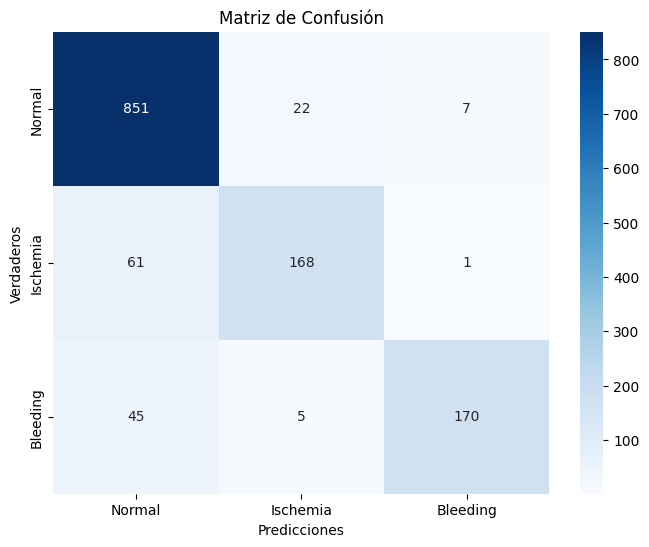

Accuracy para Normal: 96.70%
Accuracy para Ischemia: 73.04%
Accuracy para Bleeding: 77.27%


In [16]:
# Calcular el reporte de clasificación
report = classification_report(all_labels, all_predictions, target_names=["Normal", "Ischemia", "Bleeding"], output_dict=True)

# Imprimir el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(all_labels, all_predictions, target_names=["Normal", "Ischemia", "Bleeding"]))

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Normal", "Ischemia", "Bleeding"], 
            yticklabels=["Normal", "Ischemia", "Bleeding"])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

# Calcular accuracy por clase
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, class_name in enumerate(["Normal", "Ischemia", "Bleeding"]):
    print(f'Accuracy para {class_name}: {class_accuracies[i] * 100:.2f}%')